## Design Overview

This notebook demonstrates an automated workflow for Optical Mark Recognition (OMR) sheet processing using computer vision and clustering techniques. The main steps are:

1. **Preprocessing**: Images are loaded, converted to grayscale, blurred, and binarized to enhance circle detection.
2. **Circle Detection**: Hough Circle Transform is applied to identify answer bubbles in the OMR sheets.
3. **Pixel Counting**: For each detected bubble, black and white pixel counts are computed to distinguish marked and unmarked bubbles.
4. **Grouping**: Detected circles are grouped by rows using tolerance-based and clustering (DBSCAN) methods to organize bubbles per question.
5. **Mark Detection**: Differences in pixel counts between student, template, and key sheets are analyzed to identify marked answers.
6. **Scoring**: Student responses are compared to the answer key, and the total score is calculated.

## Hough Circles

In [18]:
# this is the basic idea of the circle detection in the OMR sheet
import cv2 
import numpy as np 

# Read image. 
img = cv2.imread('./Test/5_T.jpg',cv2.IMREAD_COLOR) 

# Convert to grayscale. 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)
questions = 50
options = 5
a = 18
b = 12

# Apply Hough transform on the blurred image. 
detected_circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, 1, a, 
                    param1=b, param2=3*b, minRadius=a//2, maxRadius=a)  

if detected_circles is not None:
    detected_circles = np.uint16(np.around(detected_circles))
    print(f"a:{a} b:{b} detected circles:{detected_circles.shape[1]}, Expected circles: {options*questions}")
    
    for pt in detected_circles[0, :]: 
        x, y, r = pt[0], pt[1], pt[2]  # Use different variable names to avoid conflict

        # Draw the circumference of the circle. 
        cv2.circle(img, (x, y), r, (0, 255, 0), 3) 

        # Draw a small circle to show the center. 
        cv2.circle(img, (x, y), 2, (0, 0, 255), 3) 
    
    # Resize image to make it smaller
    img = cv2.resize(img, (1200, 900))
    cv2.imshow("Detected Circle", img) 
    cv2.imwrite(f'./camera/detected_circles{a}b{b}.jpg', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No circles detected")

a:18 b:12 detected circles:250, Expected circles: 250


In [47]:
import cv2
import numpy as np

# Function to resize the image within max width and height while maintaining aspect ratio
def resize_image(image, max_width=None, max_height=None):
    (h, w) = image.shape[:2]

    if max_width is not None and max_height is not None:
        # Calculate aspect ratio to fit both width and height constraints
        if w > h:
            ratio = max_width / float(w)
            new_width = max_width
            new_height = int(h * ratio)
        else:
            ratio = max_height / float(h)
            new_height = max_height
            new_width = int(w * ratio)
    elif max_width is not None:
        ratio = max_width / float(w)
        new_width = max_width
        new_height = int(h * ratio)
    elif max_height is not None:
        ratio = max_height / float(h)
        new_height = max_height
        new_width = int(w * ratio)
    else:
        return image  # If no resizing dimensions are provided, return original image

    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# Read image
img = cv2.imread('./Test/7_S.jpg', cv2.IMREAD_COLOR)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
gray_blurred = cv2.GaussianBlur(gray, (5, 5), 0)

a = 22
b = 10

# Apply Hough transform on the blurred image
detected_circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, 1, a, 
                                    param1=b, param2=3*b, 
                                    minRadius=a//2, maxRadius=a)

# Draw circles that are detected
if detected_circles is not None:
    detected_circles = np.uint16(np.around(detected_circles))

    for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]

        # Draw the circumference of the circle
        cv2.circle(img, (a, b), r, (0, 255, 0), 3)

        # Draw a small circle to show the center
        cv2.circle(img, (a, b), 2, (0, 0, 255), 3)

        print(f"Circle found at: ({a}, {b}), radius={r}")

# Resize the image to fit within the given max width and height
resized_img = resize_image(img, max_width=1200, max_height=900)  # Change width/height as needed

# Display the resized image
cv2.imshow("Detected Circles", resized_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


Circle found at: (1108, 738), radius=17
Circle found at: (1046, 804), radius=17
Circle found at: (984, 544), radius=18
Circle found at: (230, 274), radius=18
Circle found at: (1340, 228), radius=17
Circle found at: (168, 206), radius=18
Circle found at: (1108, 804), radius=17
Circle found at: (730, 608), radius=17
Circle found at: (348, 610), radius=18
Circle found at: (612, 412), radius=18
Circle found at: (550, 346), radius=18
Circle found at: (730, 542), radius=17
Circle found at: (166, 340), radius=18
Circle found at: (1346, 544), radius=17
Circle found at: (1342, 290), radius=17
Circle found at: (1460, 418), radius=17
Circle found at: (292, 274), radius=15
Circle found at: (222, 542), radius=18
Circle found at: (156, 812), radius=17
Circle found at: (1458, 354), radius=17
Circle found at: (350, 542), radius=15
Circle found at: (732, 412), radius=15
Circle found at: (280, 816), radius=18
Circle found at: (542, 808), radius=18
Circle found at: (924, 738), radius=17
Circle found at: 

#### this to classify those clusters

In [22]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import random

def detect_circles(img, gray_blurred, questions, options):
    for b in range(15, 5, -1):
        for a in range(1, 30):
            detected_circles = cv2.HoughCircles(
                gray_blurred, cv2.HOUGH_GRADIENT, 1, a,
                param1=b, param2=3*b, minRadius=a//2, maxRadius=a
            )

            if detected_circles is not None:
                detected_circles = np.uint16(np.around(detected_circles))
                
                if detected_circles.shape[1] == questions * options:
                    pixel_counts = [(x, y, r, 0, 0) for (x, y, r) in detected_circles[0]]

                    # Group circles by rows using DBSCAN
                    rows = group_by_row_dbscan(pixel_counts)

                    # Validate if each row has clusters with 'options' circles
                    valid_rows = all(
                        len(cluster_questions_in_row(row, options)) == len(row) // options
                        for row in rows
                    )

                    if valid_rows:
                        visualize_clusters(img, rows)
                        return detected_circles[0], (a, b)

    return None, (None, None)

# Function to group circles by rows
def group_by_row_dbscan(pixel_counts, eps=10):
    y_coords = np.array([[y] for (x, y, r, black_count, white_count) in pixel_counts])
    clustering = DBSCAN(eps=eps, min_samples=1).fit(y_coords)
    labels = clustering.labels_
    rows = {}
    for label, circle_data in zip(labels, pixel_counts):
        if label not in rows:
            rows[label] = []
        rows[label].append(circle_data)
    sorted_rows = sorted(rows.values(), key=lambda row: np.mean([c[1] for c in row]))
    sorted_rows = [sorted(row, key=lambda c: c[0]) for row in sorted_rows]
    return sorted_rows

# Function to cluster questions within each row
def cluster_questions_in_row(row, options, eps=80):
    x_coords = np.array([[x] for (x, y, r, black_count, white_count) in row])
    clustering = DBSCAN(eps=eps, min_samples=1).fit(x_coords)
    labels = clustering.labels_
    questions = {}
    for label, circle_data in zip(labels, row):
        if label not in questions:
            questions[label] = []
        questions[label].append(circle_data)
    return [q for q in questions.values() if len(q) == options]

# Visualization function to display clusters with unique colors
def visualize_clusters(img, rows):
    # Assign a random color to each cluster (question) for visualization
    for row in rows:
        question_clusters = cluster_questions_in_row(row, options=4)  # Assuming options=4; adjust as needed

        # Assign a unique color for each question cluster
        for cluster in question_clusters:
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            for (x, y, r, _, _) in cluster:
                # Draw each circle with a unique color per cluster
                cv2.circle(img, (x, y), r, color, 2)
                cv2.circle(img, (x, y), 2, (0, 0, 255), 3)  # Mark the center

    cv2.imshow("Detected Circles with Clusters", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [23]:
detected = detect_circles(original_img_t, gray_blurred_t, 50, 4)

NameError: name 'original_img_t' is not defined

## Steps


### 1. Preprocessing

In [24]:
import cv2
import numpy as np


def preprocess_image(image_path, blur_ksize=(5, 5)):
    """
    Preprocess the input image by converting it to grayscale and applying Gaussian blur and convert it to binary image.
    
    Args:
        image_path (str): Path to the input image.
        blur_ksize (tuple): Kernel size for the Gaussian blur (default is (5, 5)).
        
    Returns:
        gray_blurred (numpy array): Blurred grayscale version of the image.
        original_img (numpy array): Original color image.
        gray (numpy array): Grayscale version of the image.
        binary_img (numpy array): Binary version of the image
    """
    # Read the image.
    original_img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if original_img is None:
        raise ValueError(f"Image at {image_path} not found.")
    
    # Convert to grayscale.
    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur.
    gray_blurred = cv2.GaussianBlur(gray, blur_ksize, 0)

    # Convert the original image to a binary image
    _, binary_img = cv2.threshold(gray_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return gray_blurred, original_img, gray, binary_img




In [25]:
# Preprocess the images
gray_blurred_s, original_img_s, gray_s, binary_img_s = preprocess_image('./Test/1_S.jpg')
gray_blurred_t, original_img_t, gray_t, binary_img_t = preprocess_image('./Test/1_T.jpg')
gray_blurred_k, original_img_k, gray_k, binary_img_k = preprocess_image('./Test/1_K.jpg')

questions = 50
options=4

### 2. Circle Detection

In [ ]:

def detect_circles(img, gray_blurred, questions, options):
    """
    Detect circles in the preprocessed grayscale image using the Hough Circle Transform.
    
    Args:
        img (numpy array): Original image for visualization.
        gray_blurred (numpy array): Blurred grayscale image.
        num_questions (int): Number of questions in the OMR.
        num_options (int): Number of options per question.
        dp (float): Inverse ratio of the accumulator resolution to the image resolution (default is 1).
        min_dist (int): Minimum distance between the centers of detected circles (default is 1).
        param1 (float): First method-specific parameter (gradient threshold for Canny edge detection).
        param2 (float): Second method-specific parameter (accumulator threshold for circle detection).
        min_radius_range (tuple): Tuple for minimum and maximum radius values for circle detection.
    
    Returns:
        detected_circles (numpy array): Array of detected circles, if found.
    """
    
    for b in range(20,10,-1): 
        for a in range(5,35):  
            detected_circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, 1, a, 
                            param1 = b,param2 = 3*b, minRadius = a//2, maxRadius = a) 
            if detected_circles is not None:
                detected_circles=np.uint16(np.around(detected_circles))
                print(f"circles:{detected_circles.shape[1]},a:{a},b:{b}")
                if detected_circles.shape[1]==questions*options:
                    for pt in detected_circles[0, :]: 
                        a, b, r = pt[0], pt[1], pt[2] 

                        # Draw the circumference of the circle. 
                        cv2.circle(img, (a, b), r, (0, 255, 0), 3) 

                        # Draw a small circle (of radius 1) to show the center. 
                        cv2.circle(img, (a, b), 2, (0, 0, 255), 3) 
                    cv2.imshow("Detected Circle", img) 
                    cv2.imwrite(f'./camera/detected_circles{a}b{b}.jpg', img)
                    cv2.waitKey(0) 
                    return detected_circles

    cv2.destroyAllWindows()
    return None

In [49]:
# Detect circles in the preprocessed image
detected_circles_s = detect_circles(
    original_img_s, gray_blurred_s, 
    questions, options, 
)
detected_circles_t = detect_circles(
    original_img_t, gray_blurred_t, 
    questions, options,
)

detected_circles_k = detect_circles(
    original_img_k, gray_blurred_k, 
    questions, options,
)

circles:5,a:25,b:20
circles:14,a:26,b:20
circles:89,a:27,b:20
circles:151,a:28,b:20
circles:167,a:29,b:20
circles:169,a:30,b:20
circles:171,a:31,b:20
circles:170,a:32,b:20
circles:171,a:33,b:20
circles:171,a:34,b:20
circles:8,a:25,b:19
circles:25,a:26,b:19
circles:118,a:27,b:19
circles:153,a:28,b:19
circles:172,a:29,b:19
circles:174,a:30,b:19
circles:179,a:31,b:19
circles:184,a:32,b:19
circles:187,a:33,b:19
circles:184,a:34,b:19
circles:12,a:25,b:18
circles:49,a:26,b:18
circles:137,a:27,b:18
circles:163,a:28,b:18
circles:184,a:29,b:18
circles:186,a:30,b:18
circles:189,a:31,b:18
circles:193,a:32,b:18
circles:194,a:33,b:18
circles:190,a:34,b:18
circles:3,a:12,b:17
circles:1,a:13,b:17
circles:24,a:25,b:17
circles:80,a:26,b:17
circles:145,a:27,b:17
circles:165,a:28,b:17
circles:188,a:29,b:17
circles:193,a:30,b:17
circles:196,a:31,b:17
circles:197,a:32,b:17
circles:197,a:33,b:17
circles:197,a:34,b:17
circles:7,a:12,b:16
circles:3,a:13,b:16
circles:1,a:14,b:16
circles:1,a:15,b:16
circles:2,a

### 3. Pixel counts


In [28]:
import cv2
import numpy as np

def count_black_and_white_pixels(img, circles):
    """
    Count black and white pixels in the detected circles.

    Parameters:
    - img: The binary image (where black indicates marked areas).
    - circles: List of detected circles in the format (x, y, r).

    Returns:
    - A list of tuples containing counts of (black_pixels, white_pixels) for each circle.
    """
    counts = []

    for (x, y, r) in circles:
        # Create a mask for the current circle
        mask = np.zeros_like(img, dtype=np.uint8)
        cv2.circle(mask, (x, y), r, (255), thickness=-1)  # Fill the circle in the mask

        # Apply the mask to get the pixel values within the circle
        masked_area = cv2.bitwise_and(img, mask)

        # Count black and white pixels
        black_pixels = np.sum(masked_area == 0)   # Count of black pixels (0)
        white_pixels = np.sum(masked_area == 255) # Count of white pixels (255)

        counts.append((x,y,r,black_pixels, white_pixels))

    return counts


In [55]:
circles_s = detected_circles_s[0, :]
circles_t = detected_circles_t[0, :]  
circles_k = detected_circles_k[0, :]

# Count black and white pixels in the detected circles
pixel_counts_s = count_black_and_white_pixels(binary_img_s, circles_s)
pixel_counts_t = count_black_and_white_pixels(binary_img_t, circles_t)
pixel_counts_k = count_black_and_white_pixels(binary_img_k, circles_k)

# Print the results
# print("students answer sheet")
# for idx, (x, y,r, black_count, white_count) in enumerate(pixel_counts_s, start=1):
#     print(f"Circle {idx}: Coordinates = ({x}, {y}), Black Pixels = {black_count}, White Pixels = {white_count}")

# print("template")
# for idx, (x, y,r, black_count, white_count) in enumerate(pixel_counts_t, start=1):
#     print(f"Circle {idx}: Coordinates = ({x}, {y}), Black Pixels = {black_count}, White Pixels = {white_count}")

# print("key")
# for idx, (x, y,r, black_count, white_count) in enumerate(pixel_counts_k, start=1):
#     print(f"Circle {idx}: Coordinates = ({x}, {y}), Black Pixels = {black_count}, White Pixels = {white_count}")

# Display the binary image
#cv2.imshow("Binary Image", binary_img)

# Draw the circles on the gray image for visualization
for (x, y, r) in circles_s:
    cv2.circle(original_img_s, (x, y), r, (127), 2)  
cv2.imshow("Detected Circles in gray Image student", original_img_s)
cv2.waitKey(0)



# Draw the circles on the gray image for visualization
for (x, y, r) in circles_s:
    cv2.circle(gray_blurred_s, (x, y), r, (127), 2)  
cv2.imshow("Detected Circles in gray Image student", gray_blurred_s)
cv2.waitKey(0)


# for (x, y, r) in circles_t:
#     cv2.circle(gray_blurred_t, (x, y), r, (127), 2)  
# cv2.imshow("Detected Circles in gray Image template", gray_blurred_t)
# cv2.waitKey(0)

# for (x, y, r) in circles_k:
#     cv2.circle(gray_blurred_k, (x, y), r, (127), 2)
# cv2.imshow("Detected Circles in gray Image key(scheme)", gray_blurred_k)
# cv2.waitKey(0)




# Draw the circles on the binary image for visualization
for (x, y, r) in circles_s:
    cv2.circle(binary_img_s, (x, y), r, (127), 2)  # Draw circles in a different color (grey)
cv2.imshow("Detected Circles in Binary Image student", binary_img_s)
cv2.waitKey(0)


# for (x, y, r) in circles_t:
#     cv2.circle(binary_img_t, (x, y), r, (127), 2)  
# cv2.imshow("Detected Circles in Binary Image template", binary_img_t)
# cv2.waitKey(0)

# for (x, y, r) in circles_k:
#     cv2.circle(binary_img_k, (x, y), r, (127), 2)
# cv2.imshow("Detected Circles in Binary Image key(scheme)", binary_img_k)
# cv2.waitKey(0)




cv2.destroyAllWindows()


### 4. Divide the circles by rows

##### method using tolerance

In [30]:
from collections import defaultdict
import numpy as np

def group_circles_by_rows(circles, percentage=0.5):
    # Sort circles by y-coordinate (vertical position)
    sorted_circles = sorted(circles, key=lambda x: x[1])

    # Calculate the average vertical distance between consecutive circles
    y_distances = [sorted_circles[i+1][1] - sorted_circles[i][1] for i in range(len(sorted_circles) - 1)]
    avg_distance = np.mean(y_distances)
    print(f"Average distance between circles: {avg_distance}")
    # Set the tolerance as a percentage of the average distance
    tolerance = percentage * avg_distance

    # Group circles into rows based on y-coordinate proximity
    grouped_by_rows = defaultdict(list)
    for circle in sorted_circles:
        x, y, r = circle[0], circle[1], circle[2]

        # Find the row where this circle belongs based on y-coordinate
        assigned = False
        for row_y in grouped_by_rows:
            if abs(row_y - y) < tolerance:
                grouped_by_rows[row_y].append((x, y, r))
                assigned = True
                break
        
        # If not assigned to any existing row, create a new row
        if not assigned:
            grouped_by_rows[y].append((x, y, r))

    # For each row, sort circles by x-coordinate (left to right)
    grouped_circles = []
    for row_y in sorted(grouped_by_rows.keys()):
        grouped_by_rows[row_y].sort(key=lambda c: c[0])  # Sort by x (horizontal position)
        grouped_circles.append(grouped_by_rows[row_y])

    return grouped_circles

# Example usage:
if pixel_counts is not None:
    #circles = detected_circles[0, :]  # Extract the circles from detected_circles
    
    # Group the circles by rows with a 50% tolerance of average row distance
    grouped_circles = group_circles_by_rows(pixel_counts, percentage=0.5)

    # For visualization
    question_num = 1
    for group in grouped_circles:
        print(f"Row No {question_num}:")
        for idx, (x, y, r) in enumerate(group, 1):
            print(f"circle {idx}: (x={x}, y={y}, r={r})")
            cv2.circle(original_img, (x, y), r, (0, 255, 0), 2)   # Draw the circle
            cv2.circle(original_img, (x, y), 2, (0, 0, 255), 3)   # Draw the center
        question_num += 1

    # Display the result
    cv2.imshow("Detected Circles", original_img)
    cv2.waitKey(0)

cv2.destroyAllWindows()


NameError: name 'pixel_counts' is not defined

#### Using clustering method DBSCAN


In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN


# Function to group circles by rows using DBSCAN (y-coordinate clustering)
def group_by_row_dbscan(pixel_counts, eps=10):
    # Extract the y-coordinates of circles from the pixel_counts
    y_coords = np.array([[y] for (x, y, r, black_count, white_count) in pixel_counts])
    
    # Apply DBSCAN clustering based on y-coordinates
    clustering = DBSCAN(eps=eps, min_samples=1).fit(y_coords)
    
    # Get cluster labels
    labels = clustering.labels_

    # Group circles by the row labels
    rows = {}
    for label, circle_data in zip(labels, pixel_counts):
        if label not in rows:
            rows[label] = []
        rows[label].append(circle_data)
    # sorts the clusters (rows) based on the average y-coordinate
    sorted_rows = sorted(rows.values(), key=lambda row: np.mean([c[1] for c in row]))
    # sorts the circles within each row by their x-coordinate
    sorted_rows = [sorted(row, key=lambda c: c[0]) for row in sorted_rows]
    
    return sorted_rows


In [32]:
# Group the circles by rows using the group_by_row_dbscan function
grouped_rows_s = group_by_row_dbscan(pixel_counts_s, eps=10)

# Print the grouped results
for row_idx, row in enumerate(grouped_rows_s, start=1):
    print(f"Row {row_idx}:")
    for idx, (x, y, r, black_count, white_count) in enumerate(row, start=1):
        print(f"  Circle {idx}: Coordinates = ({x}, {y}), Black Pixels = {black_count}, White Pixels = {white_count}")

Row 1:
  Circle 1: Coordinates = (104, 186), Black Pixels = 1868034, White Pixels = 1934
  Circle 2: Coordinates = (170, 188), Black Pixels = 1867956, White Pixels = 2012
  Circle 3: Coordinates = (234, 190), Black Pixels = 1869951, White Pixels = 17
  Circle 4: Coordinates = (300, 188), Black Pixels = 1868154, White Pixels = 1814
  Circle 5: Coordinates = (472, 190), Black Pixels = 1868228, White Pixels = 1740
  Circle 6: Coordinates = (536, 190), Black Pixels = 1868186, White Pixels = 1782
  Circle 7: Coordinates = (600, 188), Black Pixels = 1868040, White Pixels = 1928
  Circle 8: Coordinates = (664, 188), Black Pixels = 1869873, White Pixels = 95
  Circle 9: Coordinates = (832, 188), Black Pixels = 1868349, White Pixels = 1619
  Circle 10: Coordinates = (896, 186), Black Pixels = 1868334, White Pixels = 1634
  Circle 11: Coordinates = (954, 186), Black Pixels = 1869783, White Pixels = 185
  Circle 12: Coordinates = (1018, 186), Black Pixels = 1868153, White Pixels = 1815
Row 2:
  C

In [33]:
grouped_rows_t = group_by_row_dbscan(pixel_counts_t, eps=10)

# Print the grouped results
for row_idx, row in enumerate(grouped_rows_t, start=1):
    print(f"Row {row_idx}:")
    for idx, (x, y, r, black_count, white_count) in enumerate(row, start=1):
        print(f"  Circle {idx}: Coordinates = ({x}, {y}), Black Pixels = {black_count}, White Pixels = {white_count}")

Row 1:
  Circle 1: Coordinates = (146, 164), Black Pixels = 1876383, White Pixels = 1590
  Circle 2: Coordinates = (208, 164), Black Pixels = 1876347, White Pixels = 1626
  Circle 3: Coordinates = (268, 164), Black Pixels = 1876305, White Pixels = 1668
  Circle 4: Coordinates = (334, 162), Black Pixels = 1876413, White Pixels = 1560
  Circle 5: Coordinates = (500, 162), Black Pixels = 1876269, White Pixels = 1704
  Circle 6: Coordinates = (564, 158), Black Pixels = 1876556, White Pixels = 1417
  Circle 7: Coordinates = (628, 160), Black Pixels = 1875994, White Pixels = 1979
  Circle 8: Coordinates = (690, 158), Black Pixels = 1876296, White Pixels = 1677
  Circle 9: Coordinates = (858, 156), Black Pixels = 1876402, White Pixels = 1571
  Circle 10: Coordinates = (922, 156), Black Pixels = 1876257, White Pixels = 1716
  Circle 11: Coordinates = (986, 154), Black Pixels = 1876394, White Pixels = 1579
  Circle 12: Coordinates = (1048, 152), Black Pixels = 1876273, White Pixels = 1700
Row 2

In [35]:
grouped_rows_k = group_by_row_dbscan(pixel_counts_k, eps=10)

# Print the grouped results
for row_idx, row in enumerate(grouped_rows_k, start=1):
    print(f"Row {row_idx}:")
    for idx, (x, y, r, black_count, white_count) in enumerate(row, start=1):
        print(f"  Circle {idx}: Coordinates = ({x}, {y}), Black Pixels = {black_count}, White Pixels = {white_count}")

Row 1:
  Circle 1: Coordinates = (146, 128), Black Pixels = 1953167, White Pixels = 2033
  Circle 2: Coordinates = (218, 130), Black Pixels = 1953190, White Pixels = 2010
  Circle 3: Coordinates = (284, 132), Black Pixels = 1955142, White Pixels = 58
  Circle 4: Coordinates = (350, 132), Black Pixels = 1953226, White Pixels = 1974
  Circle 5: Coordinates = (530, 132), Black Pixels = 1953282, White Pixels = 1918
  Circle 6: Coordinates = (598, 132), Black Pixels = 1954788, White Pixels = 412
  Circle 7: Coordinates = (664, 132), Black Pixels = 1953232, White Pixels = 1968
  Circle 8: Coordinates = (732, 130), Black Pixels = 1953164, White Pixels = 2036
  Circle 9: Coordinates = (912, 128), Black Pixels = 1953008, White Pixels = 2192
  Circle 10: Coordinates = (980, 126), Black Pixels = 1953216, White Pixels = 1984
  Circle 11: Coordinates = (1048, 126), Black Pixels = 1955080, White Pixels = 120
  Circle 12: Coordinates = (1118, 124), Black Pixels = 1953068, White Pixels = 2132
Row 2:
 

### 5. Idendifying Marked and unmarked bubbles

In [36]:
def subtract_grouped_rows(grouped_rows_s, grouped_rows_t):
    """
    Subtract the black and white pixel values of grouped_rows_t from grouped_rows_s.

    Args:
        grouped_rows_s (list): List of grouped circles with pixel counts for the student's answer sheet.
        grouped_rows_t (list): List of grouped circles with pixel counts for the template.

    Returns:
        list: List of grouped circles with subtracted pixel counts.
    """
    subtracted_rows = []

    for row_s, row_t in zip(grouped_rows_s, grouped_rows_t):
        subtracted_row = []
        for (x_s, y_s, r_s, black_s, white_s), (x_t, y_t, r_t, black_t, white_t) in zip(row_s, row_t):
            subtracted_black = black_s - black_t
            subtracted_white = white_s - white_t
            subtracted_row.append((x_s, y_s, r_s, subtracted_black, subtracted_white))
        subtracted_rows.append(subtracted_row)

    return subtracted_rows

# Subtract the grouped rows
subtracted_grouped_rows = subtract_grouped_rows(grouped_rows_t, grouped_rows_s)

# Print the results
for row_idx, row in enumerate(subtracted_grouped_rows, start=1):
    print(f"Row {row_idx}:")
    for idx, (x, y, r, subtracted_black, subtracted_white) in enumerate(row, start=1):
        print(f"  Circle {idx}: Coordinates = ({x}, {y}), Subtracted Black Pixels = {subtracted_black}, Subtracted White Pixels = {subtracted_white}")

Row 1:
  Circle 1: Coordinates = (146, 164), Subtracted Black Pixels = 8349, Subtracted White Pixels = -344
  Circle 2: Coordinates = (208, 164), Subtracted Black Pixels = 8391, Subtracted White Pixels = -386
  Circle 3: Coordinates = (268, 164), Subtracted Black Pixels = 6354, Subtracted White Pixels = 1651
  Circle 4: Coordinates = (334, 162), Subtracted Black Pixels = 8259, Subtracted White Pixels = -254
  Circle 5: Coordinates = (500, 162), Subtracted Black Pixels = 8041, Subtracted White Pixels = -36
  Circle 6: Coordinates = (564, 158), Subtracted Black Pixels = 8370, Subtracted White Pixels = -365
  Circle 7: Coordinates = (628, 160), Subtracted Black Pixels = 7954, Subtracted White Pixels = 51
  Circle 8: Coordinates = (690, 158), Subtracted Black Pixels = 6423, Subtracted White Pixels = 1582
  Circle 9: Coordinates = (858, 156), Subtracted Black Pixels = 8053, Subtracted White Pixels = -48
  Circle 10: Coordinates = (922, 156), Subtracted Black Pixels = 7923, Subtracted White 

In [37]:
subtract_grouped_rows_key = subtract_grouped_rows(grouped_rows_t,grouped_rows_k)
for row_idx, row in enumerate(subtract_grouped_rows_key, start=1):
    print(f"Row {row_idx}:")
    for idx, (x, y, r, subtracted_black, subtracted_white) in enumerate(row, start=1):
        print(f"  Circle {idx}: Coordinates = ({x}, {y}), Subtracted Black Pixels = {subtracted_black}, Subtracted White Pixels = {subtracted_white}")

Row 1:
  Circle 1: Coordinates = (146, 164), Subtracted Black Pixels = -76784, Subtracted White Pixels = -443
  Circle 2: Coordinates = (208, 164), Subtracted Black Pixels = -76843, Subtracted White Pixels = -384
  Circle 3: Coordinates = (268, 164), Subtracted Black Pixels = -78837, Subtracted White Pixels = 1610
  Circle 4: Coordinates = (334, 162), Subtracted Black Pixels = -76813, Subtracted White Pixels = -414
  Circle 5: Coordinates = (500, 162), Subtracted Black Pixels = -77013, Subtracted White Pixels = -214
  Circle 6: Coordinates = (564, 158), Subtracted Black Pixels = -78232, Subtracted White Pixels = 1005
  Circle 7: Coordinates = (628, 160), Subtracted Black Pixels = -77238, Subtracted White Pixels = 11
  Circle 8: Coordinates = (690, 158), Subtracted Black Pixels = -76868, Subtracted White Pixels = -359
  Circle 9: Coordinates = (858, 156), Subtracted Black Pixels = -76606, Subtracted White Pixels = -621
  Circle 10: Coordinates = (922, 156), Subtracted Black Pixels = -76

In [38]:
import numpy as np

def detect_marked_and_unmarked_bubbles(subtracted_grouped_rows, num_options, deviation_threshold=50):
    """
    Detect marked and unmarked bubbles based on white pixel values and a deviation threshold.

    Args:
        subtracted_grouped_rows (list): List of grouped circles with subtracted pixel counts.
        num_options (int): The number of options per question.
        deviation_threshold (float): The threshold below which a question is considered unmarked.

    Returns:
        list: A 2D array where each element is:
              - 1 for the most deviated (marked) bubble.
              - 0 for unmarked bubbles.
    """
    marked_bubbles = []

    for row in subtracted_grouped_rows:
        for question_start in range(0, len(row), num_options):
            question_group = row[question_start:question_start + num_options]

            # Extract white pixel values for the current question
            white_pixel_values = [subtracted_white for (_, _, _, _, subtracted_white) in question_group]

            # Calculate the mean and standard deviation of the white pixel values
            mean_white = np.mean(white_pixel_values)
            std_dev_white = np.std(white_pixel_values)
            print(f"Mean: {mean_white}, Standard Deviation: {std_dev_white}")
            # If the standard deviation is less than the threshold, consider the question unmarked
            if std_dev_white < deviation_threshold:
                marked_bubbles.append([0] * num_options)  
            else:
                # Calculate absolute deviations from the mean
                deviations = [abs(white_value - mean_white) for white_value in white_pixel_values]

                # Create a 1D array for the question (options), initialized to zeros
                marked_question = np.zeros(num_options, dtype=int)

                # Find the index of the maximum deviation
                max_deviation_index = np.argmax(deviations)

                # Mark the option with the highest deviation as 1 (marked bubble)
                marked_question[max_deviation_index] = 1

                marked_bubbles.append(marked_question)

    return np.array(marked_bubbles)


  
answer_student = detect_marked_and_unmarked_bubbles(subtracted_grouped_rows, options)

# Print the marked bubbles in a readable format
for row_idx, row in enumerate(answer_student, start=1):
    print(f"Question {row_idx}: Marked Bubble = {row.tolist()}")


Mean: 166.75, Standard Deviation: 858.2579376271448
Mean: 308.0, Standard Deviation: 751.7296721561548
Mean: 328.25, Standard Deviation: 619.374028758068
Mean: 226.5, Standard Deviation: 791.6983327000253
Mean: 425.0, Standard Deviation: 852.8062499770977
Mean: 329.75, Standard Deviation: 553.5631739015882
Mean: 172.75, Standard Deviation: 752.1656649302732
Mean: 338.75, Standard Deviation: 644.7640556823868
Mean: 263.5, Standard Deviation: 682.5564079253817
Mean: 246.75, Standard Deviation: 819.7741685976694
Mean: 369.75, Standard Deviation: 733.0546961175544
Mean: 443.0, Standard Deviation: 616.6615765555691
Mean: 236.25, Standard Deviation: 716.5543855842346
Mean: 332.5, Standard Deviation: 739.7068676171663
Mean: 258.75, Standard Deviation: 646.6171104293483
Mean: 275.25, Standard Deviation: 747.6283752640746
Mean: 249.25, Standard Deviation: 803.7270603258297
Mean: 193.0, Standard Deviation: 684.8317311573697
Mean: 283.5, Standard Deviation: 804.4968924737994
Mean: 147.5, Standard

In [39]:
answer_key = detect_marked_and_unmarked_bubbles(subtract_grouped_rows_key, options)
for row_idx, row in enumerate(answer_key, start=1):
    print(f"Question {row_idx}: Marked Bubble = {row.tolist()}")

Mean: 92.25, Standard Deviation: 876.5216412045968
Mean: 110.75, Standard Deviation: 532.8603827457996
Mean: 34.5, Standard Deviation: 831.8667261046087
Mean: 116.75, Standard Deviation: 819.768679262632
Mean: 233.75, Standard Deviation: 846.967937704846
Mean: 85.25, Standard Deviation: 856.5635922101756
Mean: 11.5, Standard Deviation: 878.0280462490933
Mean: 169.0, Standard Deviation: 853.7590409477372
Mean: 197.25, Standard Deviation: 861.2651667750182
Mean: 150.5, Standard Deviation: 898.2122521987774
Mean: 186.5, Standard Deviation: 804.2743623913422
Mean: 118.0, Standard Deviation: 779.4789926611236
Mean: 197.0, Standard Deviation: 729.9996575341662
Mean: 123.75, Standard Deviation: 652.0281339788951
Mean: 95.75, Standard Deviation: 853.8830057449322
Mean: 110.0, Standard Deviation: 750.431542514039
Mean: 53.25, Standard Deviation: 795.889243236771
Mean: 19.5, Standard Deviation: 856.4077591895114
Mean: 123.5, Standard Deviation: 754.3628105891753
Mean: -9.75, Standard Deviation: 

### 6. Calculating score

In [40]:
def calculate_score(answer_key, answer_student):
    """
    Compare the student's answers with the answer key and calculate the score.

    Args:
        answer_key (np.ndarray): The correct answer key with marked bubbles (1 for correct option, 0 for others).
        answer_student (np.ndarray): The student's marked answers with bubbles (1 for marked option, 0 for others).

    Returns:
        int: The total score of the student.
        list: A list indicating correctness for each question (1 for correct, 0 for incorrect).
    """
    total_score = 0
    result_per_question = []

    for key, student in zip(answer_key, answer_student):
        if np.array_equal(key, student):
            total_score += 1
            result_per_question.append(1)  # Correct answer
        else:
            result_per_question.append(0)  # Incorrect answer

    return total_score, result_per_question


total_score, result_per_question = calculate_score(answer_key, answer_student)

# Print the final score and results
print(f"Total Score: {total_score}")
for idx, result in enumerate(result_per_question, start=1):
    status = "Correct" if result == 1 else "Incorrect"
    print(f"Question {idx}: {status}")


Total Score: 19
Question 1: Correct
Question 2: Incorrect
Question 3: Correct
Question 4: Correct
Question 5: Correct
Question 6: Incorrect
Question 7: Incorrect
Question 8: Incorrect
Question 9: Incorrect
Question 10: Correct
Question 11: Incorrect
Question 12: Incorrect
Question 13: Incorrect
Question 14: Incorrect
Question 15: Incorrect
Question 16: Correct
Question 17: Correct
Question 18: Incorrect
Question 19: Incorrect
Question 20: Incorrect
Question 21: Correct
Question 22: Correct
Question 23: Correct
Question 24: Incorrect
Question 25: Incorrect
Question 26: Incorrect
Question 27: Incorrect
Question 28: Incorrect
Question 29: Incorrect
Question 30: Correct
Question 31: Incorrect
Question 32: Incorrect
Question 33: Incorrect
Question 34: Incorrect
Question 35: Incorrect
Question 36: Incorrect
Question 37: Incorrect
Question 38: Incorrect
Question 39: Correct
Question 40: Incorrect
Question 41: Incorrect
Question 42: Incorrect
Question 43: Incorrect
Question 44: Correct
Questio

## extra verification step

### Group Circle by radius

this can be used to verify that the detected circles are answer circles. Now we are not using this. we will use this after we finish the core of the function.

In [41]:
import cv2
import numpy as np
from collections import defaultdict

def group_circles_by_radius(circles, img, tolerance_percentage=20):
    """
    Groups circles based on their radius with a given tolerance percentage of the y-coordinate.
    
    Args:
        circles (array): List of detected circles [(x, y, r)].
        img (numpy array): The original image.
        tolerance_percentage (float): Tolerance as a percentage of the y-coordinate (default is 20%).
        
    Returns:
        dict: Groups of circles based on their radius.
    """
    radius_groups = defaultdict(list)
    
    # Iterate over the detected circles and group them by radius
    for circle in circles:
        x, y, r = circle[0], circle[1], circle[2]

        if not radius_groups:
            # If no groups exist yet, start a new group with the first circle
            radius_groups[r].append((x, y, r))
        else:
            matched_group = None
            for existing_radius in radius_groups.keys():
                diff = abs(int(r) - int(existing_radius))
                
                # Calculate tolerance based on the radius
                tol = (tolerance_percentage / 100.0) * existing_radius

                if diff <= tol:
                    matched_group = existing_radius
                    break

            if matched_group is not None:
                radius_groups[matched_group].append((x, y, r))
            else:
                radius_groups[r].append((x, y, r))

    # Print the radius groups for debugging
    for radius, grouped_circles in radius_groups.items():
        print(f"Radius: {radius}, Circles: {grouped_circles}")
        
    # Visualize each group of circles in separate images
    for radius, grouped_circles in radius_groups.items():
        img_copy = img.copy()  # Create a copy of the original image to visualize each group
        
        for x, y, r in grouped_circles:
            cv2.circle(img_copy, (x, y), r, (0, 255, 0), 2)  # Draw outer circle
            cv2.circle(img_copy, (x, y), 2, (0, 0, 255), 3)  # Draw center

        # Display the grouped circles in a separate window
        cv2.imshow(f'Circles with radius ~ {radius}', img_copy)
        cv2.waitKey(0)
    
    return radius_groups



# if detected_circles is not None:
#     detected_circles = np.uint16(np.around(detected_circles))

#     # Call the function with the detected circles and image
#     group_circles_by_radius(detected_circles[0, :], img, tolerance_percentage=20)

cv2.destroyAllWindows()


### Contour Detection

#### test 1

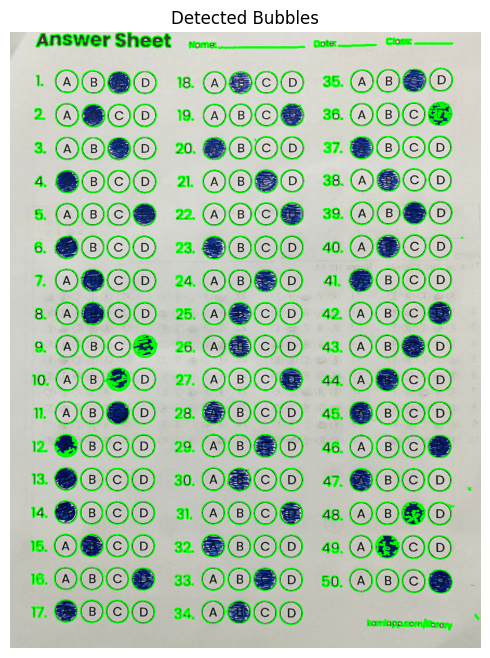

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to display images using matplotlib
def display_image(image, title="Image"):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def detectcontour(image):

    clone = image.copy()
    # Step 2: Convert to grayscale and blur
    gray_image = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Step 3: Canny Edge Detection
    edges = cv2.Canny(blurred_image, 30, 150)


    # Step 4: Finding Contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 6: Filter contours based on area (size) to detect bubbles
    bubble_contours = []
    for contour in contours:
        area = cv2.contourArea(contour) 
        bubble_contours.append(contour)

    #  Draw the detected bubbles on the original image
    output_image = image.copy()
    cv2.drawContours(output_image, bubble_contours, -1, (0, 255, 0), 2)
    display_image(output_image, "Detected Bubbles")

image = cv2.imread('./Test/1_K.jpg')
detectcontour(image)

#### method 2

In [44]:
import cv2
 
# read the image
image = cv2.imread('omr_test.png')
 
# B, G, R channel splitting
blue, green, red = cv2.split(image)
 
# detect contours using blue channel and without thresholding
contours1, hierarchy1 = cv2.findContours(image=blue, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
 
# draw contours on the original image
image_contour_blue = image.copy()
cv2.drawContours(image=image_contour_blue, contours=contours1, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
# see the results
cv2.imshow('Contour detection using blue channels only', image_contour_blue)
cv2.waitKey(0)
cv2.destroyAllWindows()
 
# detect contours using green channel and without thresholding
contours2, hierarchy2 = cv2.findContours(image=green, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# draw contours on the original image
image_contour_green = image.copy()
cv2.drawContours(image=image_contour_green, contours=contours2, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
# see the results
cv2.imshow('Contour detection using green channels only', image_contour_green)
cv2.waitKey(0)
cv2.destroyAllWindows()
 
# detect contours using red channel and without thresholding
contours3, hierarchy3 = cv2.findContours(image=red, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# draw contours on the original image
image_contour_red = image.copy()
cv2.drawContours(image=image_contour_red, contours=contours3, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
# see the results
cv2.imshow('Contour detection using red channels only', image_contour_red)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [45]:
image1 = cv2.imread('omr_test.png')
img_gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
 
ret, thresh1 = cv2.threshold(img_gray1, 150, 255, cv2.THRESH_BINARY)
contours2, hierarchy2 = cv2.findContours(thresh1, cv2.RETR_TREE,
                                               cv2.CHAIN_APPROX_SIMPLE)
image_copy2 = image1.copy()
cv2.drawContours(image_copy2, contours2, -1, (0, 255, 0), 2, cv2.LINE_AA)
cv2.imshow('SIMPLE Approximation contours', image_copy2)
cv2.waitKey(0)
image_copy3 = image1.copy()
for i, contour in enumerate(contours2): # loop over one contour area
   for j, contour_point in enumerate(contour): # loop over the points
       # draw a circle on the current contour coordinate
       cv2.circle(image_copy3, ((contour_point[0][0], contour_point[0][1])), 2, (0, 255, 0), 2, cv2.LINE_AA)
# see the results
cv2.imshow('CHAIN_APPROX_SIMPLE Point only', image_copy3)
cv2.waitKey(0)
#cv2.imwrite('contour_point_simple.jpg', image_copy3)
cv2.destroyAllWindows()